In [1]:
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score,accuracy_score,confusion_matrix,classification_report
from sklearn import preprocessing
zscore_scaler = preprocessing.StandardScaler()
class BinaryClassification:
    """
    LDA二分类
    """
    def fit(self, x, y):
        """
        :param x: 训练样本
        :param y: 训练标签
        :return:
        """
        # 将x,y转换为数组，方便接下来计算
        x = np.array(x)
        y = np.array(y)
        # 判断是否为二分类问题
        self.re = Counter(y)
        if len(self.re.keys()) != 2:
            raise ValueError("二分类问题，需要传入两类数据")

        # c1存储第一类数据,c2存储第一类数据
        c1 = []
        c2 = []
        for temp_x, temp_y in zip(x, y):
            if temp_y == list(self.re.keys())[0]:
                c1.append(temp_x)
            else:
                c2.append(temp_x)
        c1 = np.array(c1)
        c2 = np.array(c2)
        # 计算每类的平均值
        mean1 = np.mean(c1, axis=0)
        mean2 = np.mean(c2, axis=0)
        # 计算每类的方差
        var1 = np.var(c1, axis=0)
        var2 = np.var(c2, axis=0)
        # print(mean1, mean2, var1, var2)
        # 计算每类协方差
        cov1 = np.dot(c1.T, c1)/list(self.re.values())[0]
        cov2 = np.dot(c2.T, c2)/list(self.re.values())[1]
        # print(cov1)
        # print(cov2)
        # 计算类内散度矩阵Sw就是上文中的B
        Sw = cov1 + cov2
        # 计算类内散度矩阵Sb就是上文中的A
        sb = np.array(mean2 - mean1)
        Sb = np.dot(sb.reshape([-1, 1]), [sb])
        # 求解瑞利熵的最大值
        U, sigma, VT = np.linalg.svd(np.dot(np.linalg.inv(Sw), Sb))
        w = VT[0]
        # 计算每类样本中心点在超平面（直线）上的位置
        center1 = np.dot(w, mean1.T)
        center2 = np.dot(w, mean2.T)

        return w, center1, center2

    def predict(self, X, w, center1, center2):
        # 计算每个样本值的在超平面上的位置
        X = np.array(X)
        position = np.dot(w, X.T)
        # 计算样本点到各个中心点的距离
        dis1 = np.abs(position - center1)
        dis2 = np.abs(position - center2)
        # 比较样本点到两个中心点的距离的大小，样本属于距离小的点
        compare = dis1 - dis2
        # label用于存储X中数据的类别
        label = []
        for i in compare:
            if i < 0:
                label.append(list(self.re.keys())[0])
            else:
                label.append(list(self.re.keys())[1])

        return label


In [2]:
lda = BinaryClassification()
traindata = np.loadtxt("data/horseColicTraining.txt")
train_x = traindata[:,:-1]
train_y = traindata[:,-1]
w,cen1,cen2 = lda.fit(x=train_x,y=train_y)

In [3]:
y_predict = lda.predict(X=train_x,w=w,center1=cen1,center2=cen2)

In [4]:
## 定义绘制混淆矩阵的函数
import itertools
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


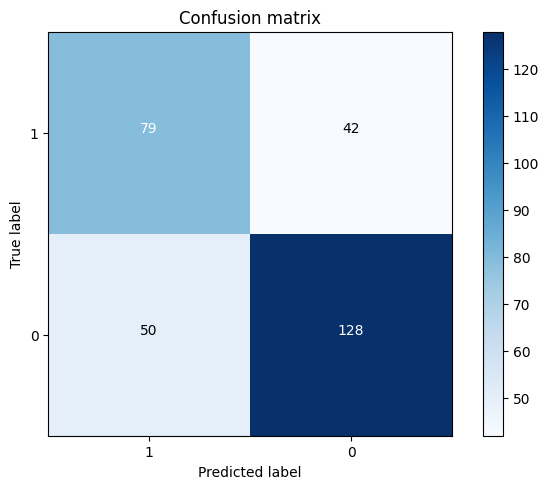

In [5]:
matrix = confusion_matrix(train_y,y_predict) #获得混淆矩阵
class_names = ['1', '0' ]
plt.figure()
plot_confusion_matrix(matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

In [6]:
print(classification_report(y_pred=y_predict,y_true=train_y)) # 测试集上的性能评价

              precision    recall  f1-score   support

         0.0       0.61      0.65      0.63       121
         1.0       0.75      0.72      0.74       178

    accuracy                           0.69       299
   macro avg       0.68      0.69      0.68       299
weighted avg       0.70      0.69      0.69       299



In [7]:
testdata = np.loadtxt("data/horseColicTest.txt")
x_test = testdata[:,:-1]
y_test = testdata[:,-1]
y_predict1 = lda.predict(X=x_test,w=w,center1=cen1,center2=cen2)

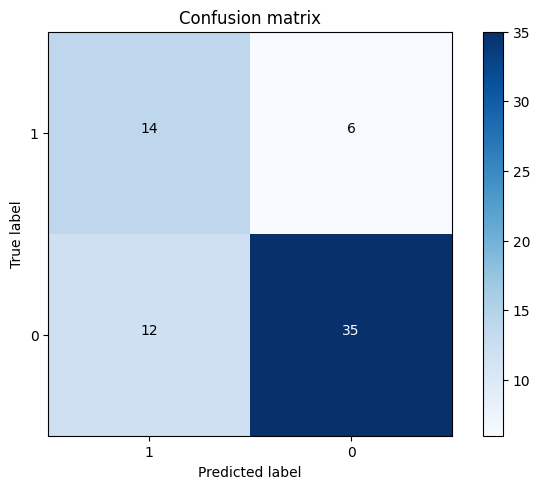

In [8]:
matrix_test = confusion_matrix(y_test,y_predict1) #获得混淆矩阵
class_names = ['1', '0' ]
plt.figure()
plot_confusion_matrix(matrix_test
                      , classes=class_names
                      , title='Confusion matrix')

# plt.savefig('./images/线性判别分析算法测试集混淆矩阵.png')
plt.show()

In [9]:
print(classification_report(y_pred=y_predict1,y_true=y_test)) # 测试集上的性能评价

              precision    recall  f1-score   support

         0.0       0.54      0.70      0.61        20
         1.0       0.85      0.74      0.80        47

    accuracy                           0.73        67
   macro avg       0.70      0.72      0.70        67
weighted avg       0.76      0.73      0.74        67

